In [26]:
%matplotlib inline

In [27]:

import pandas as pd
from pandas import Series,DataFrame

import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb



In [28]:

# get training & test csv files as a DataFrame
train_df = pd.read_csv("../input/train.csv", dtype={"Age": np.float64}, )
test_df    = pd.read_csv("../input/test.csv", dtype={"Age": np.float64}, )

# preview the data
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


In [29]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [30]:
# Encode Embarked using onehot encoding

test_df=test_df.join(pd.get_dummies(test_df.Embarked, prefix='Emb'))
train_df=train_df.join(pd.get_dummies(train_df.Embarked, prefix='Emb'))

test_df=test_df.join(pd.get_dummies(test_df.Sex, prefix='Sex'))
train_df=train_df.join(pd.get_dummies(train_df.Sex, prefix='Sex'))

In [31]:
# Lose the data we aren't interested in
test_df=test_df.drop(['Embarked','Sex','Name','Ticket','Cabin'], axis=1)
train_df=train_df.drop(['Embarked','Sex','Name','Ticket','Cabin'], axis=1)
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Emb_C,Emb_Q,Emb_S,Sex_female,Sex_male
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.188552,0.086420,0.722783,0.352413,0.647587
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.391372,0.281141,0.447876,0.477990,0.477990
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000,0.000000,1.000000,0.000000,1.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000


In [32]:
# Fill in missing Age & Fair data in train, test datasets with median age of passengers found in training data set

# IMPROVEMENT OPP -- potential improvement would be to fill in median ages by 
# class and gender categories (sample code in Kaggle tutorial)
# or drop the rows altogether
median_age = train_df.Age.median(axis=0)
train_df.Age = train_df.Age.fillna(median_age)
test_df.Age = test_df.Age.fillna(median_age)

median_fare = train_df.Fare.median(axis=0)
train_df.Fare = train_df.Fare.fillna(median_fare)
test_df.Fare = test_df.Fare.fillna(median_fare)


In [33]:
y_train_orig = train_df.iloc[:,1].values


# Keep Class, Sex, Age, Relationships, Fare, Origin in model for now
X_train_orig = train_df.iloc[:,[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
X_test_orig = test_df.iloc[:,[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]


train_col = X_train_orig.columns

In [34]:
test_col = X_test_orig.columns

In [35]:
# Normalize data fields
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# sc.fit(X_train_orig)

X_test_orig = pd.DataFrame(sc.fit_transform(X_test_orig))
X_train_orig = pd.DataFrame(sc.fit_transform(X_train_orig))
X_test_orig.columns = test_col
X_train_orig.columns = train_col

In [36]:
# Find the features that really matter in data set using Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
feat_labels = X_train_orig.columns
forest = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
forest.fit(X_train_orig, y_train_orig)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
importances


array([ 0.08572813,  0.25277036,  0.04854798,  0.03734333,  0.25700992,
        0.01216677,  0.00735274,  0.01371581,  0.1418959 ,  0.14346906])

In [37]:
indices

array([4, 1, 9, 8, 0, 2, 3, 7, 5, 6])

In [38]:
# identify the list of top features

for f in range(X_train_orig.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))


 1) Fare                           0.257010
 2) Age                            0.252770
 3) Sex_male                       0.143469
 4) Sex_female                     0.141896
 5) Pclass                         0.085728
 6) SibSp                          0.048548
 7) Parch                          0.037343
 8) Emb_S                          0.013716
 9) Emb_C                          0.012167
10) Emb_Q                          0.007353


In [39]:
# Use only top features
X_train_orig = forest.transform(X_train_orig, threshold=.05)
X_test_orig = forest.transform(X_test_orig, threshold=.05)
X_train_orig

/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


array([[ 0.82737724, -0.56573646, -0.50244517, -0.73769513,  0.73769513],
       [-1.56610693,  0.66386103,  0.78684529,  1.35557354, -1.35557354],
       [ 0.82737724, -0.25833709, -0.48885426,  1.35557354, -1.35557354],
       ..., 
       [ 0.82737724, -0.1046374 , -0.17626324,  1.35557354, -1.35557354],
       [-1.56610693, -0.25833709, -0.04438104, -0.73769513,  0.73769513],
       [ 0.82737724,  0.20276197, -0.49237783, -0.73769513,  0.73769513]])

In [40]:
# in addition to the original data sets for training (train_orig)and testing (test_orig)
# split train_orig data into training and testing sets randomly so we can obtain a practice test set with outcomes
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_orig, y_train_orig, test_size=0.25, random_state=0)

In [41]:
# Xgboost 

params = {"objective": "multi:softmax", "num_class": 8}

T_train_xgb = xgb.DMatrix(X_train, y_train)
X_test_xgb  = xgb.DMatrix(X_test)

gbm = xgb.train(params, T_train_xgb, 20)
y_pred = gbm.predict(X_test_xgb)
no_samples = len(y_test)
print('Misclassified samples: %d of %d' % ((y_test != y_pred).sum() , no_samples))

from sklearn.metrics import accuracy_score
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Misclassified samples: 35 of 223
Accuracy: 0.84


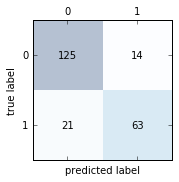

In [42]:
# Determine number of true-positives, false-positives, true-negatives, false-negatives to see if model can be 
# optimized
from sklearn.metrics import confusion_matrix
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[i]):
        ax.text(x=j, y=i,
               s=confmat[i,j],
               va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [47]:
# Xgboost 

params = {"objective": "multi:softmax", "num_class": 8}

T_train_xgb = xgb.DMatrix(X_train_orig, y_train_orig)
X_test_xgb  = xgb.DMatrix(X_test_orig)

gbm = xgb.train(params, T_train_xgb, 20)
y_pred_orig = gbm.predict(X_test_xgb)
y_pred_orig = y_pred_orig.astype(int)
y_pred_orig.sum()

133

In [48]:
output = test_df.PassengerId
output = pd.DataFrame(output)
# len(output)
predict = pd.DataFrame(y_pred_orig)
output = output.join(predict)
output.columns = ['PassengerId', 'Survived']
output

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,0
7,899,0
8,900,0
9,901,0


In [49]:
output.to_csv("../input/output.csv", index=False)